In [11]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
import numpy as np
import pandas as pd 
from scipy import signal
import statistics
import matplotlib.pyplot as plt
import math
import os
import glob
import seaborn as sns; sns.set()

def mode_signal_generation(leg_pool, mode_pool):
  raw_dir = "/content/drive/My Drive/ML Data/Offline Mode Classification Raw Data/"
  window_size = 350
  transition_point = 0.2
  
  trial_pool = [1, 2, 3]
  subject_pool = ["06", "07", "08", "09", "10", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "23", "24", "25", "27", "28"]

  transition1_average_signal = []
  transition2_average_signal = []
  # Reading Data Files
  for subject in subject_pool:

      transition1_signal = []
      transition2_signal = []
      for mode in mode_pool:
          for trial in trial_pool:
              for starting_leg in leg_pool:
                  data_path = raw_dir+"AB"+subject+"_"+str(mode)+"_S2_"+str(starting_leg)+"_T"+str(trial)+".csv"

                  if os.path.exists(data_path) == 1:
                      for data_read_path in glob.glob(data_path):
                          data = pd.read_csv(data_read_path, header=0)
                          feature_data = data.iloc[:, :-3].to_numpy()
                          mode_label = data.iloc[:, -3].to_numpy()
                          
                  # Segmenting data out into first and second transition gait cycle
                  transition_mode_diff = np.where(np.diff(np.transpose(mode_label))!=0)[0]          
                  transition_1 = feature_data[np.arange(0, transition_mode_diff[0]+1)]
                  transition_2 = feature_data[np.arange(transition_mode_diff[1]+1, len(mode_label))]
                  
                  # Upsampling the signal and append to a list
                  transition1_raw_signal = []
                  transition2_raw_signal = []
                  for ii in np.arange(0, np.shape(transition_1)[1]):
                      transition1_raw_signal.append(np.interp(np.linspace(0, 100, 1000), np.linspace(0, 100, len(transition_1)), transition_1[:, ii]))
                      transition2_raw_signal.append(np.interp(np.linspace(0, 100, 1000), np.linspace(0, 100, len(transition_2)), transition_2[:, ii]))
                  # Appending the upsampled trial data to a subject signal
                  transition1_signal.append(transition1_raw_signal)
                  transition2_signal.append(transition1_raw_signal)

      # Averaging the signal within the subject and appending to a total array
      transition1_average_signal.append(np.mean(transition1_signal, axis = 0))
      transition2_average_signal.append(np.mean(transition2_signal, axis = 0))

  # Computing mean and std of the sensor signal across subjects
  transition1_mean_signal = np.mean(transition1_average_signal, axis = 0)
  transition1_std_signal = np.std(transition1_average_signal, axis = 0)
  transition2_mean_signal = np.mean(transition2_average_signal, axis = 0)
  transition2_std_signal = np.std(transition2_average_signal, axis = 0)

  return transition1_mean_signal, transition1_std_signal, transition2_mean_signal, transition2_std_signal

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
def LG_steady_signal():
  raw_dir = "/content/drive/My Drive/ML Data/Offline Mode Classification Raw Data/"
  subject_pool = ["06", "07", "08", "09", "10", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "23", "24", "25", "27", "28"]
  trial_pool = [1, 2, 3]

  # Reading Data Files
  subject_mean_signal = []
  for subject in subject_pool:
    for trial in trial_pool:
      data_path = raw_dir+"AB"+subject+"_LG_S2_T"+str(trial)+".csv"
      if os.path.exists(data_path) == 1:
        for data_read_path in glob.glob(data_path):
          data = pd.read_csv(data_read_path, header=0)
          feature_data = data.iloc[:, :-3].to_numpy()
          gc_label = data.iloc[:, -2].to_numpy()

      hc_idx = np.where(gc_label == 0)[0]
      final_signal = []
      for ii in np.arange(len(hc_idx)-1):
        signal = []
        for jj in np.arange(0, np.shape(feature_data)[1]):
          one_gc_feature = feature_data[hc_idx[ii]:hc_idx[ii+1]-1]
          shift_signal_1 = one_gc_feature[0:int(len(one_gc_feature)*0.6), :]
          shift_signal_2 = one_gc_feature[int(len(one_gc_feature)*0.6):len(one_gc_feature), :]
          new_shift_signal = np.concatenate((shift_signal_2, shift_signal_1), axis=0)
          signal.append(np.interp(np.linspace(0, 100, 1000), np.linspace(0, 100, len(one_gc_feature)), new_shift_signal[:, jj]))
        final_signal.append(signal)
    subject_mean_signal.append(np.mean(final_signal, axis = 0))

  LG_mean = np.mean(subject_mean_signal, axis = 0)
  LG_std = np.std(subject_mean_signal, axis = 0)

  return LG_mean, LG_std

In [9]:
def mode_steady_signal(mode_pool):
  raw_dir = "/content/drive/My Drive/ML Data/Offline Mode Classification Raw Data/"
  subject_pool = ["06", "07", "08", "09", "10", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "23", "24", "25", "27", "28"]
  trial_pool = [1, 2, 3]
  starting_leg = ["R"]

  # Reading Data Files
  subject_mean_signal = []
  for subject in subject_pool:
    
    trial_mean_signal = []
    for trial in trial_pool:
      
      mode_mean_signal = []
      for mode in mode_pool:
        data_path = raw_dir+"AB"+subject+"_"+str(mode)+"_S2_"+str(starting_leg)+"_T"+str(trial)+".csv"

        if os.path.exists(data_path) == 1:
          for data_read_path in glob.glob(data_path):
            data = pd.read_csv(data_read_path, header=0)
            feature_data = data.iloc[:, :-3].to_numpy()
            gc_label = data.iloc[:, -2].to_numpy()
            mode_label = data.iloc[:, -3].to_numpy()
                          
            hc_idx = np.where(gc_label == 0)[0]
            hc_idx = hc_idx[1:-1]

            final_signal = []
            for ii in np.arange(len(hc_idx)-1):
              signal = []
              for jj in np.arange(0, np.shape(feature_data)[1]):
                one_gc_feature = feature_data[hc_idx[ii]:hc_idx[ii+1]-1]
                shift_signal_1 = one_gc_feature[0:int(len(one_gc_feature)*0.6), :]
                shift_signal_2 = one_gc_feature[int(len(one_gc_feature)*0.6):len(one_gc_feature), :]
                new_shift_signal = np.concatenate((shift_signal_2, shift_signal_1), axis=0)
                signal.append(np.interp(np.linspace(0, 100, 1000), np.linspace(0, 100, len(one_gc_feature)), new_shift_signal[:, jj]))
              final_signal.append(signal)
          mode_mean_signal.append(np.mean(final_signal, axis = 0))
        trial_mean_signal.append(np.mean(mode_mean_signal, axis = 0))
    subject_mean_signal.append(np.mean(trial_mean_signal, axis = 0))

  mode_mean = np.mean(subject_mean_signal, axis = 0)
  mode_std = np.std(subject_mean_signal, axis = 0)

  return mode_mean, mode_std

In [10]:
LG_mean, LG_std = LG_steady_signal()
RA_mean, RA_std = mode_steady_signal(["RA2", "RA3", "RA4", "RA5"])
RD_mean, RD_std = mode_steady_signal(["RD2", "RD3", "RD4", "RD5"])
SA_mean, SA_std = mode_steady_signal(["SA1", "SA2", "SA3", "SA4"])
SD_mean, SD_std = mode_steady_signal(["SD1", "SD2", "SD3", "SD4"])
RA_mean1, RA_std1, RA_mean2, RA_std2 = mode_signal_generation(["R"], ["RA2", "RA3", "RA4", "RA5"])
RD_mean1, RD_std1, RD_mean2, RD_std2 = mode_signal_generation(["R"], ["RD2", "RD3", "RD4", "RD5"])
SA_mean1, SA_std1, SA_mean2, SA_std2 = mode_signal_generation(["R"], ["SA1", "SA2", "SA3", "SA4"])
SD_mean1, SD_std1, SD_mean2, SD_std2 = mode_signal_generation(["R"], ["SD1", "SD2", "SD3", "SD4"])

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
RA_transition_1 = abs(RA_mean1 - LG_mean) / LG_std
RA_transition_2 = abs(RA_mean2 - RA_mean) / RA_std
RD_transition_1 = abs(RD_mean1 - LG_mean) / LG_std
RD_transition_2 = abs(RD_mean2 - RD_mean) / RD_std
SA_transition_1 = abs(SA_mean1 - LG_mean) / LG_std
SA_transition_2 = abs(SA_mean2 - SA_mean) / SA_std
SD_transition_1 = abs(SD_mean1 - LG_mean) / LG_std
SD_transition_2 = abs(SD_mean2 - SD_mean) / SD_std

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:208: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Text(0.5, 1.0, 'SD to LG')

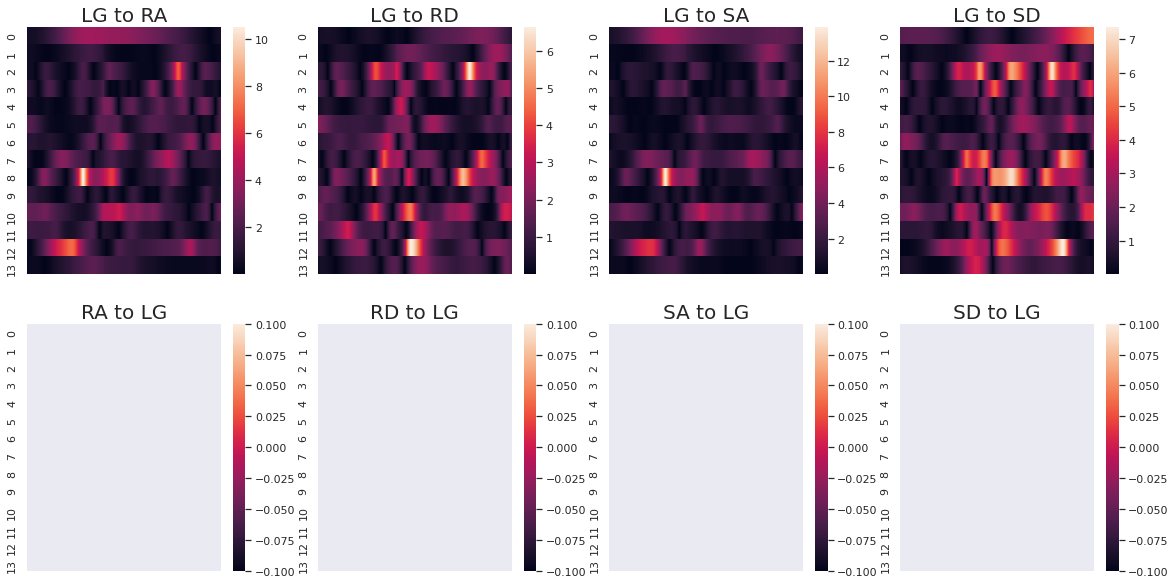

In [12]:
# ax1 = sns.heatmap(RA_transition_1)

fig = plt.figure(figsize = (20,10)) # width x height
ax1 = fig.add_subplot(2, 4, 1) # row, column, position
ax2 = fig.add_subplot(2, 4, 5)
ax3 = fig.add_subplot(2, 4, 2)
ax4 = fig.add_subplot(2, 4, 6)
ax5 = fig.add_subplot(2, 4, 3)
ax6 = fig.add_subplot(2, 4, 7)
ax7 = fig.add_subplot(2, 4, 4)
ax8 = fig.add_subplot(2, 4, 8)

sns.heatmap(RA_transition_1, ax=ax1, xticklabels=False)
sns.heatmap(RA_transition_2, ax=ax2, xticklabels=False)
sns.heatmap(RD_transition_1, ax=ax3, xticklabels=False)
sns.heatmap(RD_transition_2, ax=ax4, xticklabels=False)
sns.heatmap(SA_transition_1, ax=ax5, xticklabels=False)
sns.heatmap(SA_transition_2, ax=ax6, xticklabels=False)
sns.heatmap(SD_transition_1, ax=ax7, xticklabels=False)
sns.heatmap(SD_transition_2, ax=ax8, xticklabels=False)

ax1.set_title('LG to RA', fontsize=20)
ax2.set_title('RA to LG', fontsize=20)
ax3.set_title('LG to RD', fontsize=20)
ax4.set_title('RD to LG', fontsize=20)
ax5.set_title('LG to SA', fontsize=20)
ax6.set_title('SA to LG', fontsize=20)
ax7.set_title('LG to SD', fontsize=20)
ax8.set_title('SD to LG', fontsize=20)